In [ ]:
# Установка необходимых нестандартных пакетов
!pip install uproot3

     |████████████████████████████████| 117 kB 7.4 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 


In [ ]:
# Подключение пакетов
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral

plt.rcParams['font.size'] = 12

print('Uproot version:',uproot.version.version)
print('Numpy version:', np.version.version)

# инициализация генератора псевдослучайных чисел
rng = np.random.default_rng(12345)

Uproot version: 3.14.4
Numpy version: 1.21.6


In [ ]:
# Проверка среды выполнения СoLab/Local и монтирование гугл-диска
if 'google.colab' in str(get_ipython()):
  from google.colab import drive 
  drive.mount('/mnt')  # смонтировать гугл-диск в папке «mntDrive»   
  datadir = '/mnt/My Drive/FARICH/Reconstruction/NN/data'
  picsdir = '/mnt/My Drive/FARICH/Reconstruction/NN/pics'
else:
  print('Not running on CoLab!')
  os.exit(1)

Mounted at /mnt


In [ ]:
# отображение ключей в файле uproot в виде иерархии
def show_uproot_tree(obj, maxkeylen=12, sep='/', indent=0) -> None:
  width = maxkeylen+len(sep)
  startline = False
  if isinstance(obj, uproot.rootio.ROOTDirectory):
    print('TFile: '+obj.name.decode('utf-8'))
    startline = True
    indent = 2
  elif issubclass(type(obj), uproot.tree.TTreeMethods):
    print('TTree: '+obj.name.decode('utf-8'))
    startline = True
    indent = 4
  else:
    if len(obj.keys()) > 0:
      indent += width
      s = obj.name.decode('utf-8')[:maxkeylen]
      print(s + ' '*(maxkeylen-len(s)) + sep, end='')
    else:
      print(obj.name.decode('utf-8'))

  if len(obj.keys()) > 0:
    for i, key in enumerate(obj.keys()):
      if i>0 or startline:
        print(' '*indent, end='')
      show_uproot_tree(obj[key], indent=indent)
    indent -= width

In [ ]:
filepath = os.path.join(datadir, 'pi-pi-', 'rndm', 'farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root')
show_uproot_tree(uproot.open(filepath))

TFile: ./farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root
  TTree: info_sim
    info_gen    /m_num_events
                 m_z_dis
    info_rad    /m_layers    /m_layers.first
                              m_layers.second
    info_pmt    /m_name
                 m_num_side_x
                 m_num_side_y
                 m_gap
                 m_size
                 m_chip_num_size
                 m_chip_pitch
                 m_chip_size
                 m_chip_offset
                 m_focal_length
                 m_trg_window
                 m_origin_pos/m_origin_pos._2
                              m_origin_pos._1
                              m_origin_pos._0
  TTree: raw_data
    event       /m_id_event
                 m_id_primary
                 m_pos_primar/m_pos_primary._2
                              m_pos_primary._1
                              m_pos_primary._0
                 m_dir_primar/m_dir_primary._2
                              m_dir_primary._1


In [ ]:
def readInfoFromRoot(filepath, verbose: bool = True) -> pd.DataFrame:
  '''
  Получение информации о моделировании из ROOT-файла в виде датафрейма формой (1, N), где N - число параметров моделирования.
  '''
  # Названия используемых колонок данных для переименования и сохранения в data frame
  idf_rename_map = {'m_num_events': 'nevents',  # число событий моделирования
                    'm_z_dis': 'zdis',  # расстояние от места рождения частицы до входа в радиатор в мм
                    'm_layers': 'nlayers',  # число слоев радиатора
                    'm_size': 'array_size',  # размер матрицы КФУ в мм
                    'm_gap': 'array_gap',  # зазор между матрицами КФУ в мм
                    'm_chip_size': 'pixel_size',  # размер пикселя КФУ в мм
                    'm_chip_pitch': 'pixel_gap',  # зазор между пикселями КФУ в мм
                    'm_chip_num_size': 'pixel_numx',  # размер матрицы КФУ в пикселях
                    'm_num_side_x': 'nxarrays', 'm_num_side_y': 'nyarrays',  # размер фотодетектора в матрицах КФУ по X и Y
                    'm_focal_length': 'distance',  # расстояние от входа в радиатор до входа в фотодетектор
                    'm_trg_window': 'trg_window_ns',  # размер временного окна в нс
                    'W': 'W',  # толщина радиатора в мм (вычисляемая)
                    'n_mean': 'n_mean',  # средний показатель преломления радиатора (вычисляемый)
                    'n_max': 'n_max',  # максимальный показатель преломления радиатора (вычисляемый)
                   }

  # Открытие ROOT-файла с данными используя Uproot https://github.com/scikit-hep/uproot3
  with uproot.open(filepath) as file:
    idf = file[b'info_sim'].pandas.df('*', flatten=False)

  # Переименование параметров
  idf.rename(columns=idf_rename_map, inplace=True, errors='ignore')

  # Получение параметров (многослойного) радиатора одинаковых для всех файлов
  n_l = idf.at[0,'m_layers.first']  # показатели преломления слоёв
  w_l = idf.at[0,'m_layers.second']  # толщины слоёв радиатора

  W = w_l.sum()  # суммарная толщина всех слоёв
  n_mean = n_l.mean()  # средний показатель преломления
  n_max = n_l.max()  # максимальный показатель преломления

  # Добавление вычисляемых параметров в idf
  idf['W'] = W
  idf['n_mean'] = n_mean
  idf['n_max'] = n_max

  # Сохранение нужных параметров
  idf = idf[idf_rename_map.values()]

  if verbose:
    for name in idf.columns:
      print(f'{name}: {idf.at[0, name]}')

  return idf

In [ ]:
idf = readInfoFromRoot(filepath)

nevents: 1200000
zdis: 1.0
nlayers: 4
array_size: 26.68
array_gap: 1.0
pixel_size: 3.16
pixel_gap: 0.2
pixel_numx: 8
nxarrays: 30
nyarrays: 30
distance: 200.0
trg_window_ns: 20.0
W: 35.0
n_mean: 1.0453999999999999
n_max: 1.05


In [ ]:
def genChunkFromRoot(filepath, eventchunksize=2000, noisefreqpersqmm: float = 2e6, noiseTimeRange: float = (0, 7), shiftSignalTimes: bool = True,
                     edfstore: pd.HDFStore = None, verbose: bool = True) -> pd.DataFrame:
  '''
  Генератор событий из ROOT-файла в виде датафрейма. Число событий eventchunksize, читаемых генератором за один раз, должно выбираться так,
  чтобы все данные с учетом добавляемых шумовых срабатываний умещались в размер ОЗУ.

  Параметры:
    filepath - путь к ROOT-файлу для чтения.
    eventchunksize - число событий, загружаемых из ROOT-файла за один вызов.
    noisefreqpersqmm - частота темновых срабатываний на единицу активной площади фотодетектора в с^{-1}*мм^{-2}, подмешиваемых к событиям;
                     максимальное значение параметра, которое имеет смысл рассматривать -- 2e6.
    noiseTimeRange - (start, stop) -- tuple, задающий временной интервал генерации шума в наносекундах.
    shiftSignalTimes - если True, случайно смещать времена сигнальных срабатываний в пределах временного окна генерации шума.
    edfstore - HDF-хранилище для записи датафрейма "edf"; данные добавляются к уже записанным в хранилище.
    verbose - флаг отладочной печати.
  
  Описание условий моделирования:
    Ось Z направлена вдоль нормали к плоскости радиатора от радиатора к фотодетектору.
    Оси X и Y паралельны осям симметрии матрицы фотодетектора.
    Первичная частица (отрицательный пион) вылетает на расстоянии zdis=1 мм перед радиатором в его сторону
    Начальное положение частицы случайно разбрасывается по X и Y в квадрате со стороной (pixel_size+pixel_gap).
    Направление частицы случайно разбрасывается в телесном угле в пределах theta_p=[0, π/4], phi_p=[0, 2π].
    Скорость частицы случайно и равномерно разбрасывается от 0.957 до 0.999 скорости света.
  '''
  global rng

  # Данные о частице (для переименования и сохранения)
  part_rename_map = {'m_hits': 'nhits',           # число срабатываний в событии
                     'm_pos_primary._0': 'x_p',   # X-координата вылета частицы в мм
                     'm_pos_primary._1': 'y_p',   # Y-координата вылета частицы в мм
                     'm_pos_primary._2': 'z_p',   # Z-координата вылета частицы в мм
                     'm_dir_primary._0': 'nx_p',  # X-компонента единичного вектора направления частицы
                     'm_dir_primary._1': 'ny_p',  # Y-компонента единичного вектора направления частицы
                     'm_dir_primary._2': 'nz_p',  # Z-компонента единичного вектора направления частицы
                     'm_beta_primary': 'beta',    # скорость частицы в единицах скорости света
                     'm_theta_primary': 'theta_p',# полярный угол направления частицы в радианах
                     'm_phi_primary': 'phi_p',    # азимутальный угол направления частицы в радианах
                     'm_momentum_primary': 'momentum'  # импульс частицы в МэВ/c
                    }
  
  # Наблюдаемые данные о срабатываниях (для переименования и сохранения)
  hit_rename_map = {'m_hits.m_photon_pos_chip._0': 'x_c',  # X-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._1': 'y_c',  # Y-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._2': 'z_c',  # Z-координата срабатывания в мм
                    'm_hits.m_photon_time': 't_c'          # время срабатывания в нс
                   }

  # Наименования колонок для сохранения в датафрейм
  edfcolstosave = list(part_rename_map.values()) + list(hit_rename_map.values())

  # Чтение параметров моделирования
  idf = readInfoFromRoot(filepath)

  # Определения параметров фотодетектора для генерации темнового шума
  pixel_size, pixel_gap = idf.at[0, 'pixel_size'], idf.at[0, 'pixel_gap']
  array_size, array_gap = idf.at[0, 'array_size'], idf.at[0, 'array_gap']
  nxpixels_arr = idf.at[0, 'pixel_numx']
  nxpixels_tot = idf.at[0, 'nxarrays']*nxpixels_arr
  igrid = np.arange(nxpixels_tot//2)
  xpnts = array_gap/2 + (igrid//nxpixels_arr)*(array_size+array_gap) + (igrid%nxpixels_arr)*(pixel_size+pixel_gap) + pixel_size/2
  xpnts = np.sort(np.append(-xpnts, xpnts)).astype('float32')
  xgrid, ygrid = np.meshgrid(xpnts, xpnts)
  xgrid = xgrid.reshape(xgrid.size)
  ygrid = ygrid.reshape(ygrid.size)
 
  def addNoise(partdf: pd.DataFrame, hitdf: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Генерация темновых срабатываний темнового шума и добавление в датафрейм (без учета "мёртвого" времени пикселя).
    partdf - датафрейм для частиц
    hitdf - датафрейм для срабатываний
    '''
    assert(np.isclose(pixel_size*nxpixels_arr+pixel_gap*(nxpixels_arr-1), array_size))
    nevents = partdf.shape[0]  # число событий
    
    # среднее число шумовых срабатываний на событие
    munoise = (noiseTimeRange[1]-noiseTimeRange[0])*1e-9*noisefreqpersqmm*(pixel_size**2)*(nxpixels_tot**2)

    print(f'    Generate noise with DCR per mm^2 {noisefreqpersqmm}, mean number of hits per event: {munoise:.2f}.')

    noisehits = rng.poisson(munoise, nevents)   # генерация массива числа шумовых срабатываний в событиях по пуассоновскому распределению
    Ndc = int(noisehits.sum())                  # общее число шумовых срабатываний (скаляр)
    signalhits = partdf['nhits'].to_numpy()     # массив числа сигнальных срабатываний по событиям

    # случайное смещение сигнальных срабатываний в пределах временного окна генерации шума
    if shiftSignalTimes:
      hitdf['t_c'] += np.repeat(rng.uniform(0, noiseTimeRange[1]-2, nevents), partdf['nhits'])

    hitdf['signal'] = np.ones(signalhits.sum(), bool)  # разметка сигнальных срабатываний значением 'signal' True
    if Ndc == 0:    # если нет шумовых срабатываний
      return hitdf  # возвращаем исходный датафрейм с добавлением колонки 'signal'

    ich = rng.choice(xgrid.size, Ndc)           # генерация случайных номеров сработавших каналов с возможным повтором
    xh = xgrid[ich]                             # x-координата сработавших каналов
    yh = ygrid[ich]                             # y-координата сработавших каналов
    zh = hitdf.at[(0, 0), 'z_c']                # z-координата срабатываний (скаляр)
    th = rng.uniform(noiseTimeRange[0], noiseTimeRange[1], size=Ndc) # генерация времён срабатываний по однородному распределению
   
    # нумерация шумовых срабатываний по событиям
    ievent = np.repeat(partdf.index, noisehits) # массив номеров событий для записи в датафрейм
    ihit = np.zeros(Ndc, 'int64')               # инициализация массива номеров срабатываний для записи в датафрейм
    index = 0
    for i in range(nevents):
      ihit[index:index+noisehits[i]] = signalhits[i] + np.arange(noisehits[i])
      index += noisehits[i]
    
    # создание датафрейма с шумовыми срабатываниями того же формата, что hitdf
    noisedf = pd.DataFrame({'x_c': xh, 'y_c': yh, 'z_c': zh, 't_c': th, 'signal': np.zeros(Ndc, bool)},
                           index=pd.MultiIndex.from_arrays((ievent, ihit), names=('entry', 'subentry')))

    # TO DO: случайное смещение кольца в фотодетекторе (сдвиг координат сигнальных хитов).
    # Сложность с реализацией для неравномерной сетки пикселей, т.к. зазоры между матрицами больше зазоров между пикселями в матрице.

    # сливаем сигнальный и шумовой датафрейм и сортируем указатель событий и срабатываний
    hitdf2 = pd.concat((hitdf, noisedf), copy=False).sort_index(level=('entry', 'subentry'))

    # обновляем количества срабатываний в partdf, добавляя количества шумовых срабатываний по событиям
    partdf['nhits'] += noisehits

    return hitdf2


  nFileEvents = idf.at[0, 'nevents']
  print(f'Processing ROOT file {filepath} with {nFileEvents} simulated events...', flush=True)
  
  # Цикл чтения кусков ROOT-файла
  for partdf, hitdf in zip(uproot.pandas.iterate(filepath, "raw_data", part_rename_map.keys(), entrysteps=eventchunksize), 
                           uproot.pandas.iterate(filepath, "raw_data", hit_rename_map.keys(), entrysteps=eventchunksize, flatten=True)):
    print('\n  Processing next chunk...')

    # Переименование колонок
    partdf.rename(columns=part_rename_map, inplace=True, errors='raise')
    hitdf.rename(columns=hit_rename_map, inplace=True, errors='raise')

    partdf = partdf.astype('float32', copy=False)
    partdf['nhits'] = partdf['nhits'].astype('int32', copy=False)
    hitdf = hitdf.astype('float32', copy=False)

    # Генерация и добавление шумовых срабатываний
    hitdf = addNoise(partdf, hitdf)

    print(f'    {hitdf.index.levels[0].size} entries with {hitdf.shape[0]} hits to process')

    # Слияние данных событий и срабатываний
    edf = hitdf.join(partdf, on='entry')

    if verbose:
      print(edf)

    if edfstore is not None:
      print(f'    Saving edf chunk...')
      edfstore.put('edf', edf, format='table', append=True)

    yield edf

In [ ]:
# Чтение и домоделирование одного "куска" данных
#edf = next(genChunkFromRoot(filepath, 5000, noisefreqpersqmm=100000))
edf = next(genChunkFromRoot(filepath, 5000, noisefreqpersqmm=0))

nevents: 1200000
zdis: 1.0
nlayers: 4
array_size: 26.68
array_gap: 1.0
pixel_size: 3.16
pixel_gap: 0.2
pixel_numx: 8
nxarrays: 30
nyarrays: 30
distance: 200.0
trg_window_ns: 20.0
W: 35.0
n_mean: 1.0453999999999999
n_max: 1.05
Processing ROOT file /mnt/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root with 1200000 simulated events...

  Processing next chunk...
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    4984 entries with 156933 hits to process
                       x_c         y_c  ...     phi_p    momentum
entry subentry                          ...                      
0     0         -70.879997 -226.880005  ...  4.607758  528.209290
      1         -53.279999 -309.920013  ...  4.607758  528.209290
      2         -36.480000 -306.559998  ...  4.607758  528.209290
      3         -49.919998 -184.960007  ...  4.607758  528.209290
      4         -12.160000 -288.959991  ...  4.607758  5

In [ ]:
def recoAngles(edf: pd.DataFrame, idf: pd.DataFrame):
  '''
  Геометрическая реконструкция углов фотонов относительно направления частицы.
  Из координат срабатываний и частиц вычисляются углы theta_c, phi_c и время вылета фотонов t_c_orig и добавляются к edf.
  '''
  r0 = edf.loc[:, ('x_p', 'y_p', 'z_p')].to_numpy()
  n0 = edf.loc[:, ('nx_p', 'ny_p', 'nz_p')].to_numpy()
  r  = edf.loc[:, ('x_c', 'y_c', 'z_c')].to_numpy()

  speedOfLight_mmperns = 299.792458 # мм/нс

  # толщина радиатора
  W = float(idf['W'])

  # расстояние от точки вылета частицы до входной плоскости радиатора
  rad_pos = float(idf['zdis'])

  # полное число срабатываний
  N = edf.shape[0]

  # косинусы и синусы сферических углов направления частицы
  costheta, sintheta = n0[:,2], np.sqrt(n0[:,0]**2+n0[:,1]**2)
  phi = np.arctan2(n0[:,1], n0[:,0])
  cosphi, sinphi = np.cos(phi), np.sin(phi)

  # номинальная точка вылета фотонов
  ro = r0 + (W/2+rad_pos)/n0[:,2].reshape(N,1)*n0

  """
  Преобразование в СК частицы
  𝑢𝑥 = cos 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) − 𝑣𝑧 sin 𝜃,
  𝑢𝑦 = −𝑣𝑥 sin 𝜙 + 𝑣𝑦 cos 𝜙,
  𝑢𝑧 = sin 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) + 𝑣𝑧 cos 𝜃.
  """

  # вектор направления фотона в лабораторной СК
  s = (r-ro)
  snorm = np.linalg.norm(s, axis=1, keepdims=True)
  v = s / snorm

  edf['t_c_orig'] = edf['t_c'] - (snorm / speedOfLight_mmperns).reshape(N)

  # освобождение памяти при необходимости
  #del r0, n0, ro, r, s

  U = np.stack((np.stack((costheta*cosphi, costheta*sinphi, -sintheta)),
                np.stack((-sinphi,         cosphi,          np.full(N, 0.))),
                np.stack((sintheta*cosphi, sintheta*sinphi, costheta)))).transpose(2,0,1)

  # единичный вектор направления фотона в СК частицы
  u = (U @ v.reshape(N,3,1)).reshape(N,3)

  # сферические углы фотона в СК частицы
  edf['theta_c'] = np.arccos(u[:,2])
  edf['phi_c'] = np.arctan2(-u[:,1], -u[:,0])


In [ ]:
recoAngles(edf, idf)

In [ ]:
def plothits(edf: pd.DataFrame, events: int = 1, first: int = 0, trange: tuple = None):
  '''
  Отрисовка срабатываний в датафрейме edf в виде распределений по координатам, углам и времени.
  Параметры:
  edf - датафрейм для отрисовки
  events - число событий для отрисовки
  first - рисовать, начиная с этого события
  '''  

  edf = edf.loc[(first, 0):(first+events, -1)]
  xh = edf['x_c'].to_numpy()
  yh = edf['y_c'].to_numpy()
  zh = edf['z_c'].to_numpy()
  th = edf['t_c'].to_numpy()
  sh = edf['signal'].to_numpy()

  print(f'Number of events to plot: {events}')
  print('Momenta, MeV/c:', ' '.join([f'{p:.1f}' for p in edf['momentum'].unique()]))
  print('Incident angles, degrees:', ' '.join([f'{t:.1f}' for t in edf['theta_p'].unique()*180/np.pi]))
  print(f"Number of hits to plot: {sh.size}")
  print(f"Number of signal hits: {sh.sum():d}")
  print("(Xmin, Xmax):", xh.min(), xh.max())
  print("(Tmin, Tmax):", th.min(), th.max())

  figxy0 = plt.figure(figsize=(6,6))
  plt.plot(xh, yh, 'k.')  # все срабатывания
  #plt.plot([-400, 400], [0, 0], 'k-')
  #plt.plot([0, 0], [-400, 400], 'k-')
  plt.xlabel('Xhit, mm', fontsize=14)
  plt.ylabel('Yhit, mm', fontsize=14)
  plt.tight_layout()

  figxy = plt.figure(figsize=(6,6))
  plt.plot(xh[sh], yh[sh], 'r.', label='Signal')  # сигнальные срабатывания
  if not sh.all():
    plt.plot(xh[~sh], yh[~sh], 'k.', label='Noise')  # шумовые срабатывания
    plt.legend()
  #plt.plot([-400, 400], [0, 0], 'k-')
  #plt.plot([0, 0], [-400, 400], 'k-')
  plt.xlabel('Xhit, mm', fontsize=14)
  plt.ylabel('Yhit, mm', fontsize=14)
  plt.tight_layout()

  figtime = plt.figure(figsize=(6,4))
  if not sh.all():
    _, bins, _ = plt.hist([th[sh], th[~sh]], bins=100, color=['r', 'k'], histtype='stepfilled', label=['Signal', 'Noise'])
    plt.legend()
  else:
    _, bins, _ = plt.hist(th[sh], bins=100, range=trange, color='r', histtype='stepfilled')
  dt = bins[1] - bins[0]
  plt.xlabel('Thit, ns', fontsize=14)
  plt.ylabel(f'Hits/({dt:.3f} ns)', fontsize=14)
  if (isinstance(trange, tuple) or isinstance(trange, list)) and len(trange) == 2:
    plt.xlim(trange)
  #plt.semilogy()
  plt.tight_layout()

  if 't_c_orig' in edf.columns:
    toh = edf['t_c_orig'].to_numpy()
    figtime_orig = plt.figure(figsize=(6,4))
    plt.hist([toh[sh], toh[~sh]], bins=100, range=trange, color=['r', 'k'], histtype='stepfilled', label=['Signal', 'Noise'])
    plt.xlabel('Time of photon origin, ns', fontsize=14)
    plt.ylabel(f'Hits/({dt:.3f} ns)', fontsize=14)
    if not sh.all():
      plt.legend()
    #plt.semilogy()
    plt.tight_layout()

  figangles = None
  if 'theta_c' in edf.columns and 'phi_c' in edf.columns:
    figangles = plt.figure(figsize=(6,4))
    theta_c = edf['theta_c'].to_numpy()
    phi_c = edf['phi_c'].to_numpy()
    plt.plot(phi_c[sh], theta_c[sh], 'r.', label='Signal')
    if not sh.all():
      plt.plot(phi_c[~sh], theta_c[~sh], 'k.', label='Noise')
      plt.legend()
    plt.xlim(-np.pi*1.05, np.pi*1.05)
    plt.ylim(0., np.arccos(1/1.05)*2)
    plt.xlabel(r'$\phi_c$', fontsize=14)
    plt.ylabel(r'$\theta_c$', fontsize=14)
    plt.tight_layout()

  return figxy0, figxy, figtime, figangles

Number of events to plot: 1
Momenta, MeV/c: 1374.9
Incident angles, degrees: 12.6
Number of hits to plot: 461
Number of signal hits: 49
(Xmin, Xmax): -409.76 413.12
(Tmin, Tmax): 0.009285270377007548 6.975248901967531


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


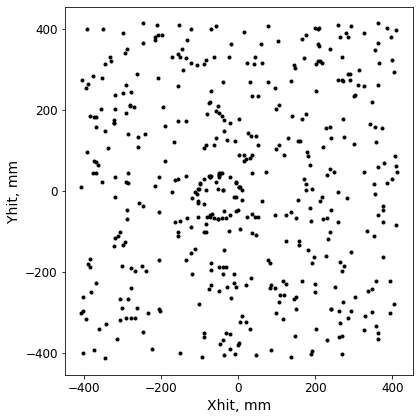

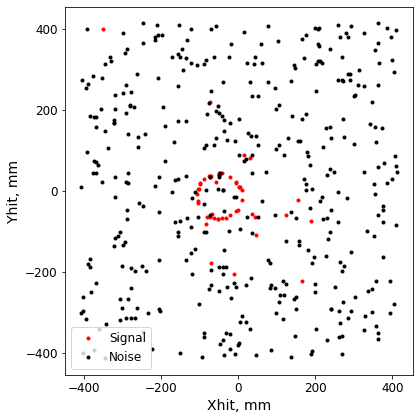

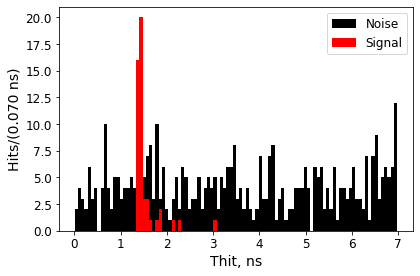

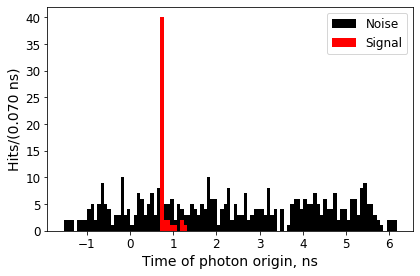

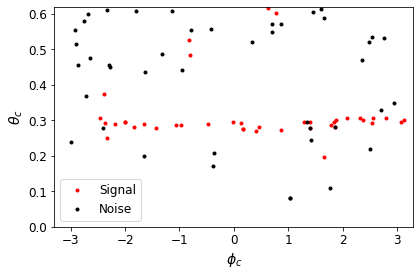

In [ ]:
figxy0, figxy, figtime, figangles = plothits(edf, 1, 5)

nevents: 1200000
zdis: 1.0
nlayers: 4
array_size: 26.68
array_gap: 1.0
pixel_size: 3.16
pixel_gap: 0.2
pixel_numx: 8
nxarrays: 30
nyarrays: 30
distance: 200.0
trg_window_ns: 20.0
W: 35.0
n_mean: 1.0453999999999999
n_max: 1.05
Processing ROOT file /mnt/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root with 1200000 simulated events...

  Processing next chunk...
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    1992 entries with 63072 hits to process
                       x_c         y_c  ...     phi_p   momentum
entry subentry                          ...                     
0     0         -70.879997 -226.880005  ...  4.607758  528.20929
      1         -53.279999 -309.920013  ...  4.607758  528.20929
      2         -36.480000 -306.559998  ...  4.607758  528.20929
      3         -49.919998 -184.960007  ...  4.607758  528.20929
      4         -12.160000 -288.959991  ...  4.607758  528.2092

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


nevents: 1200000
zdis: 1.0
nlayers: 4
array_size: 26.68
array_gap: 1.0
pixel_size: 3.16
pixel_gap: 0.2
pixel_numx: 8
nxarrays: 30
nyarrays: 30
distance: 200.0
trg_window_ns: 20.0
W: 35.0
n_mean: 1.0453999999999999
n_max: 1.05
Processing ROOT file /mnt/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root with 1200000 simulated events...

  Processing next chunk...
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 402.62.
    2000 entries with 868878 hits to process
                       x_c         y_c  ...     phi_p   momentum
entry subentry                          ...                     
0     0         -70.879997 -226.880005  ...  4.607758  528.20929
      1         -53.279999 -309.920013  ...  4.607758  528.20929
      2         -36.480000 -306.559998  ...  4.607758  528.20929
      3         -49.919998 -184.960007  ...  4.607758  528.20929
      4         -12.160000 -288.959991  ...  4.607758

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


nevents: 1200000
zdis: 1.0
nlayers: 4
array_size: 26.68
array_gap: 1.0
pixel_size: 3.16
pixel_gap: 0.2
pixel_numx: 8
nxarrays: 30
nyarrays: 30
distance: 200.0
trg_window_ns: 20.0
W: 35.0
n_mean: 1.0453999999999999
n_max: 1.05
Processing ROOT file /mnt/My Drive/FARICH/Reconstruction/NN/data/pi-pi-/rndm/farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root with 1200000 simulated events...

  Processing next chunk...
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 4026.19.
    2000 entries with 8118202 hits to process
                       x_c         y_c  ...     phi_p   momentum
entry subentry                          ...                     
0     0         -70.879997 -226.880005  ...  4.607758  528.20929
      1         -53.279999 -309.920013  ...  4.607758  528.20929
      2         -36.480000 -306.559998  ...  4.607758  528.20929
      3         -49.919998 -184.960007  ...  4.607758  528.20929
      4         -12.160000 -288.959991  ...  4.607

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


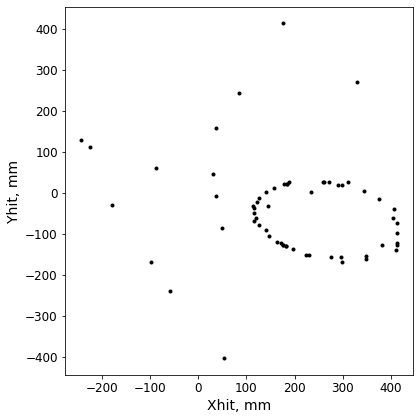

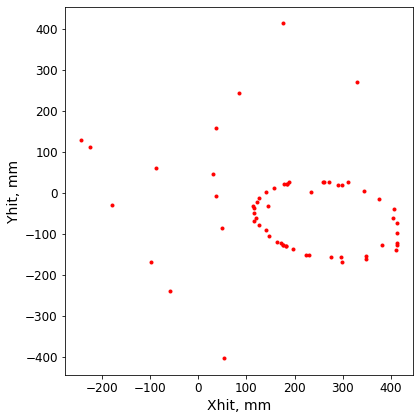

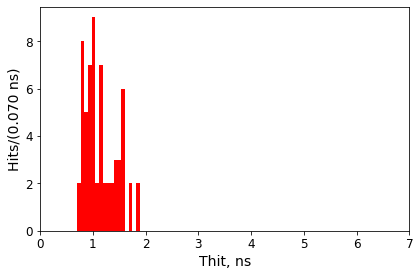

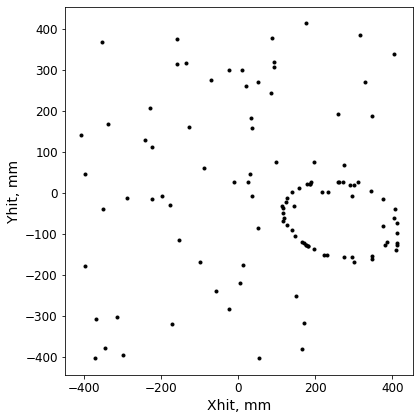

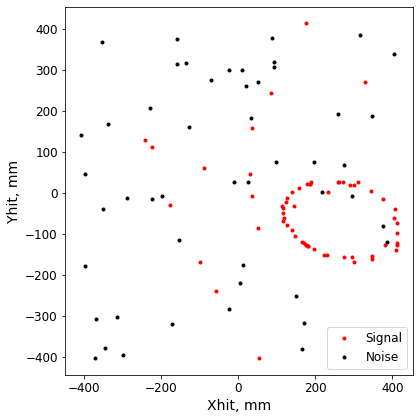

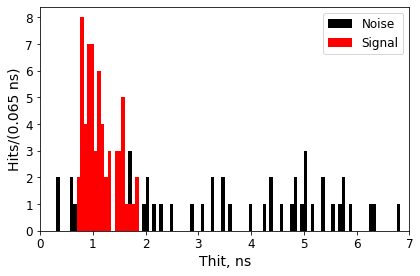

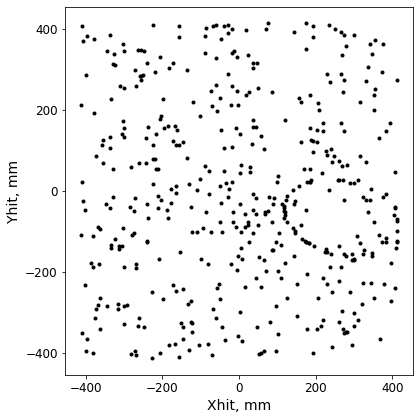

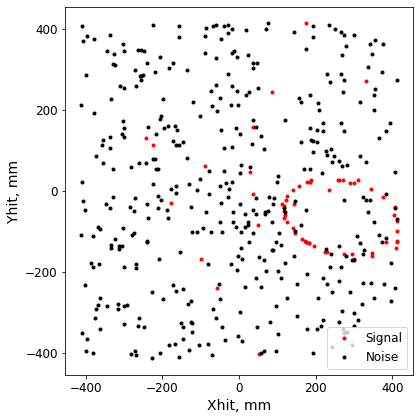

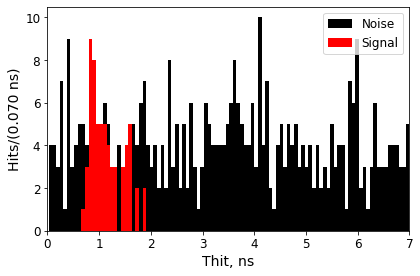

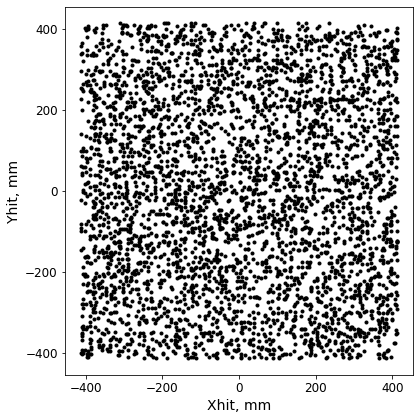

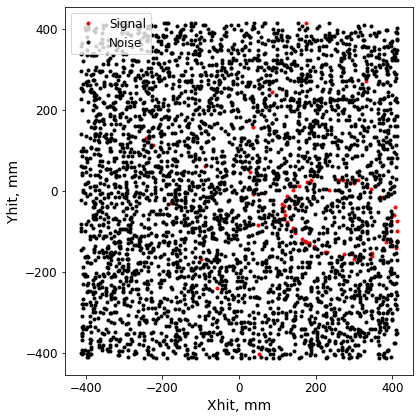

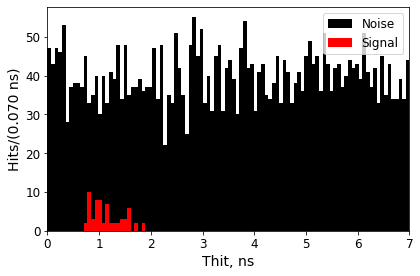

In [ ]:
event = 1444
momentum = edf.at[(event, 0), 'momentum']
theta_p = edf.at[(event, 0), 'theta_p']*180/np.pi
for dcr in [0, 1e4, 1e5, 1e6]:
  edf = next(genChunkFromRoot(filepath, 2000, noisefreqpersqmm=dcr, shiftSignalTimes=False))
  figxy0, figxy, figtime, _ = plothits(edf, 1, event, trange=(0, 7))
  figxy.savefig(os.path.join(picsdir, f'labeled_ring_pi_p{momentum:.0f}mev_theta{theta_p:.0f}deg_dcr{dcr:.3g}.png'))
  figtime.savefig(os.path.join(picsdir, f'labeled_time_pi_p{momentum:.0f}mev_theta{theta_p:.0f}deg_dcr{dcr:.3g}.png'))

In [ ]:
#edf[(edf['theta_p'] > 44.9/180*np.pi) & (edf['momentum'] > 1500)]

In [ ]:
#figangles.savefig(os.path.join(picsdir, 'labeled_angles_pi_p245mev_theta45deg.png'))

In [ ]:
#figxy0.savefig(os.path.join(picsdir, 'unlabeled_ring_pi_p1375mev_theta12deg.png'))
#figxy.savefig(os.path.join(picsdir, 'labeled_ring_pi_p1375mev_theta12deg.png'))
#figtime.savefig(os.path.join(picsdir, 'labeled_time_pi_p1375mev_theta12deg.png'))
#if figangles is not None:
#  figangles.savefig(os.path.join(picsdir, 'labeled_angles_pi_p1375mev_theta12deg.png'))